# Import libraries

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Linear Regression Model").getOrCreate()

In [2]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import IndexToString, StringIndexer

# Load and verify data

In [3]:
data = spark.read.csv('ASRI.csv',header = True, inferSchema = True)

In [4]:
data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: integer (nullable = true)
 |-- High: integer (nullable = true)
 |-- Low: integer (nullable = true)
 |-- Close: integer (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Frequency: double (nullable = true)



In [5]:
data.head(3)

[Row(Date=datetime.date(2020, 1, 2), Open=0, High=240, Low=236, Close=238, Volume='3.323.600', Value='789.137.000', Frequency=647.0),
 Row(Date=datetime.date(2020, 1, 3), Open=0, High=240, Low=236, Close=236, Volume='15.815.400', Value='3.751.160.600', Frequency=1.071),
 Row(Date=datetime.date(2020, 1, 6), Open=0, High=236, Low=232, Close=234, Volume='3.246.300', Value='759.807.800', Frequency=400.0)]

In [6]:
for item in data.head(1)[0]:
    print(item)

2020-01-02
0
240
236
238
3.323.600
789.137.000
647.0


In [7]:
data.columns

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value', 'Frequency']

In [8]:
data.groupBy('Close').count().show()

+-----+-----+
|Close|count|
+-----+-----+
|  133|    3|
|  108|    3|
|  155|   16|
|  193|    4|
|  101|    1|
|  115|    5|
|  126|    3|
|  210|    2|
|  183|   19|
|  192|    3|
|  159|   13|
|  236|   14|
|  222|    1|
|  128|    7|
|  230|    2|
|  122|    2|
|  232|    5|
|  157|   12|
|  190|   10|
|  246|    4|
+-----+-----+
only showing top 20 rows



# Data Preprocessing

In [9]:
indexer_volume = StringIndexer(inputCol='Volume', outputCol='VolumeIndex')
indexer_value = StringIndexer(inputCol='Value', outputCol='ValueIndex')

In [10]:
# Fitting dan transforming DataFrame
indexed = indexer_volume.fit(data).transform(data)
indexed = indexer_value.fit(indexed).transform(indexed)

In [11]:
indexed.show()

+----------+----+----+---+-----+----------+-------------+---------+-----------+----------+
|      Date|Open|High|Low|Close|    Volume|        Value|Frequency|VolumeIndex|ValueIndex|
+----------+----+----+---+-----+----------+-------------+---------+-----------+----------+
|2020-01-02|   0| 240|236|  238| 3.323.600|  789.137.000|    647.0|      486.0|     889.0|
|2020-01-03|   0| 240|236|  236|15.815.400|3.751.160.600|    1.071|      195.0|     527.0|
|2020-01-06|   0| 236|232|  234| 3.246.300|  759.807.800|    400.0|      480.0|     880.0|
|2020-01-07|   0| 238|232|  236| 3.340.600|  783.695.400|    554.0|      488.0|     886.0|
|2020-01-08|   0| 236|230|  232| 2.501.900|  581.224.600|    457.0|      312.0|     747.0|
|2020-01-09|   0| 236|230|  234| 4.490.100|1.039.827.000|      1.3|      604.0|       5.0|
|2020-01-10|   0| 236|232|  234|13.398.500|3.132.553.600|    562.0|      126.0|     465.0|
|2020-01-13|   0| 248|232|  246|27.439.200|6.649.311.000|    2.047|      444.0|     780.0|

In [12]:
indexed.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: integer (nullable = true)
 |-- High: integer (nullable = true)
 |-- Low: integer (nullable = true)
 |-- Close: integer (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Frequency: double (nullable = true)
 |-- VolumeIndex: double (nullable = false)
 |-- ValueIndex: double (nullable = false)



In [13]:
assembler = VectorAssembler(inputCols =['Open', 'High', 'Low', 'Close','Frequency'],
                            outputCol='features')

In [14]:
output = assembler.transform(indexed)

In [15]:
output.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: integer (nullable = true)
 |-- High: integer (nullable = true)
 |-- Low: integer (nullable = true)
 |-- Close: integer (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Frequency: double (nullable = true)
 |-- VolumeIndex: double (nullable = false)
 |-- ValueIndex: double (nullable = false)
 |-- features: vector (nullable = true)



In [16]:
print(output.features)

Column<'features'>


In [17]:
output.head(1)

[Row(Date=datetime.date(2020, 1, 2), Open=0, High=240, Low=236, Close=238, Volume='3.323.600', Value='789.137.000', Frequency=647.0, VolumeIndex=486.0, ValueIndex=889.0, features=DenseVector([0.0, 240.0, 236.0, 238.0, 647.0]))]

In [18]:
final_data = output.select('features','Close')

In [19]:
final_data.show()

+--------------------+-----+
|            features|Close|
+--------------------+-----+
|[0.0,240.0,236.0,...|  238|
|[0.0,240.0,236.0,...|  236|
|[0.0,236.0,232.0,...|  234|
|[0.0,238.0,232.0,...|  236|
|[0.0,236.0,230.0,...|  232|
|[0.0,236.0,230.0,...|  234|
|[0.0,236.0,232.0,...|  234|
|[0.0,248.0,232.0,...|  246|
|[0.0,250.0,244.0,...|  246|
|[0.0,246.0,240.0,...|  242|
|[0.0,242.0,234.0,...|  236|
|[0.0,240.0,232.0,...|  234|
|[0.0,238.0,230.0,...|  230|
|[0.0,230.0,218.0,...|  218|
|[0.0,220.0,212.0,...|  212|
|[0.0,216.0,210.0,...|  212|
|[0.0,218.0,212.0,...|  212|
|[0.0,216.0,210.0,...|  212|
|[0.0,216.0,208.0,...|  212|
|[0.0,216.0,208.0,...|  210|
+--------------------+-----+
only showing top 20 rows



# Train Test split

In [20]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [21]:
train_data.describe().show()

+-------+-----------------+
|summary|            Close|
+-------+-----------------+
|  count|              667|
|   mean|  170.76011994003|
| stddev|32.38918782979714|
|    min|               92|
|    max|              278|
+-------+-----------------+



In [22]:
test_data.describe().show()

+-------+------------------+
|summary|             Close|
+-------+------------------+
|  count|               307|
|   mean| 171.4527687296417|
| stddev|34.002982623240676|
|    min|               104|
|    max|               288|
+-------+------------------+



# Build Model

In [23]:
regressor = LinearRegression(labelCol='Close')

In [24]:
model = regressor.fit(train_data)

# Evaluate Model

In [25]:
pred_data = model.evaluate(test_data)

In [26]:
pred_data.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|1.920656274023713...|
|2.234975227111135...|
|7.544578295437532E-8|
|-2.64199414345966...|
|1.748310864968516...|
|-6.83757093611348E-7|
|-3.67847860616166...|
|-3.68402979233906...|
|-5.15645837140255E-8|
|-4.10486421742461...|
|2.259147890981694...|
|-3.05245180243218...|
|1.195960663835649E-7|
|-3.02355815051669...|
|5.932569990818592...|
|-2.43623759388356...|
|-2.44931072757026...|
|-2.39358982412341E-7|
|-2.41396648448244...|
|2.151504929770453...|
+--------------------+
only showing top 20 rows



In [27]:
pred_data.rootMeanSquaredError

3.39862916402102e-07

In [28]:
pred_data.r2

0.9999999999999999

In [29]:
pred_data.meanSquaredError

1.1550680194534218e-13

In [30]:
pred_data.meanAbsoluteError

2.718866754783579e-07

In [31]:
from pyspark.sql import functions as f
data.select(f.corr('Close', 'Low')).show()

+------------------+
|  corr(Close, Low)|
+------------------+
|0.9923580470600794|
+------------------+



In [32]:
unlabeled_data = test_data.select('features')
test_predictions = model.transform(unlabeled_data)

In [33]:
test_predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[0.0,109.0,101.0,...|103.99999980793437|
|[0.0,111.0,106.0,...|109.99999977650248|
|[0.0,112.0,100.0,...|103.99999992455422|
|[0.0,114.0,105.0,...|113.00000026419941|
|[0.0,114.0,107.0,...|107.99999982516891|
|[0.0,115.0,106.0,...| 106.0000006837571|
|[0.0,115.0,111.0,...|112.00000036784786|
|[0.0,115.0,112.0,...|112.00000036840298|
|[0.0,116.0,112.0,...|113.00000005156458|
|[0.0,117.0,109.0,...|113.00000041048642|
|[0.0,117.0,111.0,...|113.99999997740852|
|[0.0,117.0,113.0,...|115.00000030524518|
|[0.0,118.0,113.0,...|112.99999988040393|
|[0.0,118.0,114.0,...|116.00000030235582|
|[0.0,119.0,111.0,...| 111.9999999406743|
|[0.0,119.0,111.0,...|118.00000024362376|
|[0.0,119.0,114.0,...|118.00000024493107|
|[0.0,120.0,115.0,...|119.00000023935898|
|[0.0,120.0,118.0,...|119.00000024139665|
|[0.0,121.0,110.0,...| 113.9999997848495|
+--------------------+------------

# Visualisasi Saham

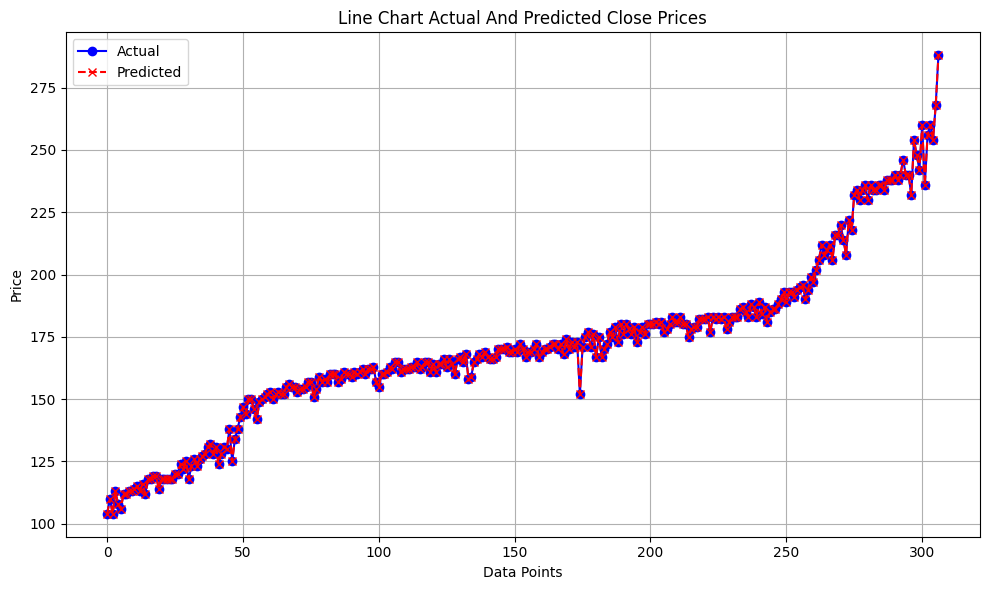

In [34]:
import matplotlib.pyplot as plt
# Mendapatkan prediksi dari test data
predictions = test_predictions.select('prediction').collect()
actual_values = test_data.select('Close').collect()

# Mengonversi hasil prediksi dan nilai aktual ke dalam list
predicted_values = [row['prediction'] for row in predictions]
actual_values_list = [row['Close'] for row in actual_values]

# Membuat line chart
plt.figure(figsize=(10, 6))

# Plot nilai aktual
plt.plot(actual_values_list, label='Actual', marker='o', linestyle='-', color='blue')

# Plot hasil prediksi
plt.plot(predicted_values, label='Predicted', marker='x', linestyle='--', color='red')

# Menambahkan label sumbu x dan y, judul, dan legend
plt.xlabel('Data Points')
plt.ylabel('Price')
plt.title('Line Chart Actual And Predicted Close Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Menampilkan line chart
plt.show()

Index(['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value', 'Frequency'], dtype='object')


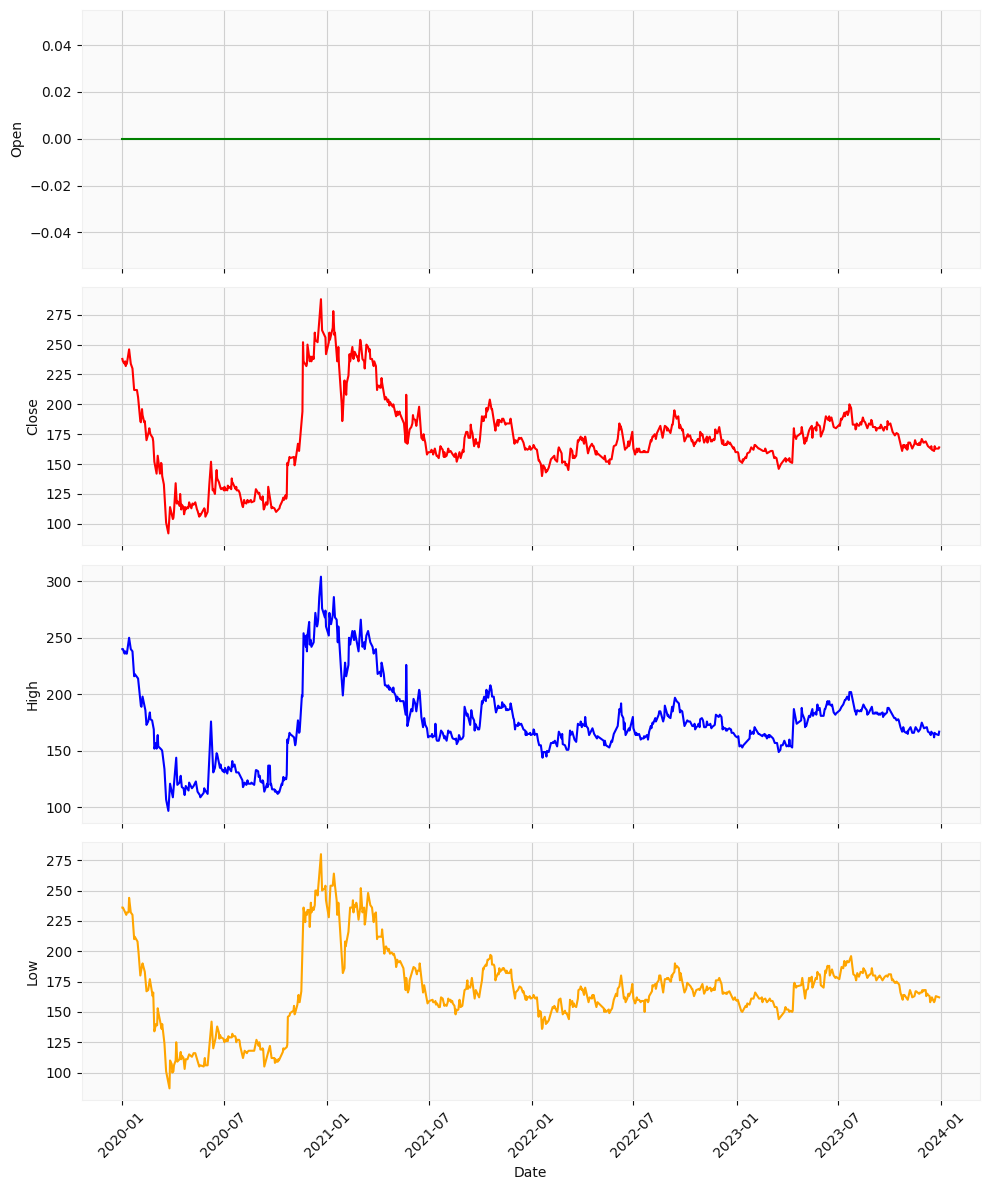

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Mengonversi DataFrame Spark menjadi Pandas DataFrame
pandas_df = data.toPandas()

# Melihat nama-nama kolom yang ada dalam DataFrame
print(pandas_df.columns)

# Menggunakan nama kolom yang sesuai sebagai indeks (ganti 'Nama_Kolom_Date' dengan nama kolom yang sesuai)
pandas_df['date'] = pd.to_datetime(pandas_df['date'])
pandas_df.set_index('date', inplace=True)

# Membuat subplots untuk setiap aspek harga
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plotting candlestick chart untuk Open, Close, High, Low
# Pastikan nama kolom yang digunakan sesuai dengan DataFrame Anda
axs[0].plot(pandas_df.index, pandas_df['Open'], color='green', linestyle='-')
axs[0].set_ylabel('Open')
axs[1].plot(pandas_df.index, pandas_df['Close'], color='red',  linestyle='-')
axs[1].set_ylabel('Close')
axs[2].plot(pandas_df.index, pandas_df['High'], color='blue', linestyle='-')
axs[2].set_ylabel('High')
axs[3].plot(pandas_df.index, pandas_df['Low'], color='orange', linestyle='-')
axs[3].set_ylabel('Low')

# Memberikan judul umum dan label sumbu x
plt.xlabel('Date')

# Menampilkan chart
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


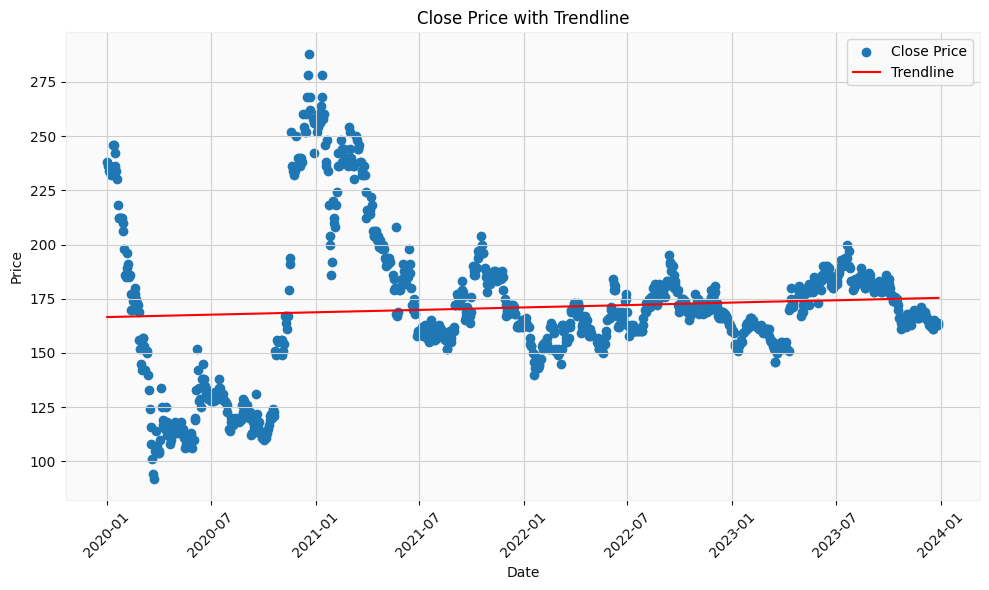

In [41]:
import matplotlib.pyplot as plt
import numpy as np 
from pyspark.sql import functions as F

# Assuming 'date' and 'close' are the respective column names in your Spark DataFrame
data = data.withColumn('date', F.to_date('date', 'yyyy-MM-dd'))

# Convert Spark DataFrame to Pandas DataFrame for visualization
data_pd = data.select('date', 'close').toPandas()

# Sort the data by date if it's not sorted already
data_pd.sort_values('date', inplace=True)

# Extracting x and y values for plotting
x = data_pd['date']
y = data_pd['close']

# Plot the stock price data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Close Price')

# Fit a trendline (linear regression) using numpy.polyfit
z = np.polyfit(x.index.values, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x.index.values), color='red', label='Trendline')

plt.title('Close Price with Trendline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()
